## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [1]:
%matplotlib inline

In [22]:
import matplotlib.pyplot as plt

import pandas
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier


### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-22 07:50:19--  https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932820 (911K) [application/octet-stream]
Saving to: 'public_train_10000.root'

100%[======================================>] 932,820     4.06MB/s   in 0.2s   

2016-06-22 07:50:20 (4.06 MB/s) - 'public_train_10000.root' saved [932820/932820]



In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-22 07:50:37--  https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9245432 (8.8M) [application/octet-stream]
Saving to: 'public_train_100000.root'

100%[======================================>] 9,245,432   9.45MB/s   in 0.9s   

2016-06-22 07:50:38 (9.45 MB/s) - 'public_train_100000.root' saved [9245432/9245432]



In [5]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-22 07:50:41--  https://2016.mlhep.yandex.net/data/higgs/public_test.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91931408 (88M) [application/octet-stream]
Saving to: 'public_test.root'

100%[======================================>] 91,931,408  25.4MB/s   in 3.9s   

2016-06-22 07:50:45 (22.5 MB/s) - 'public_test.root' saved [91931408/91931408]



### Read the smallest part of training file and test file

In [92]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_100000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
features = list(set(data.columns) - {'event_id', 'target'})
print(len(features))
features

28


['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

### Plot histograms for each feature

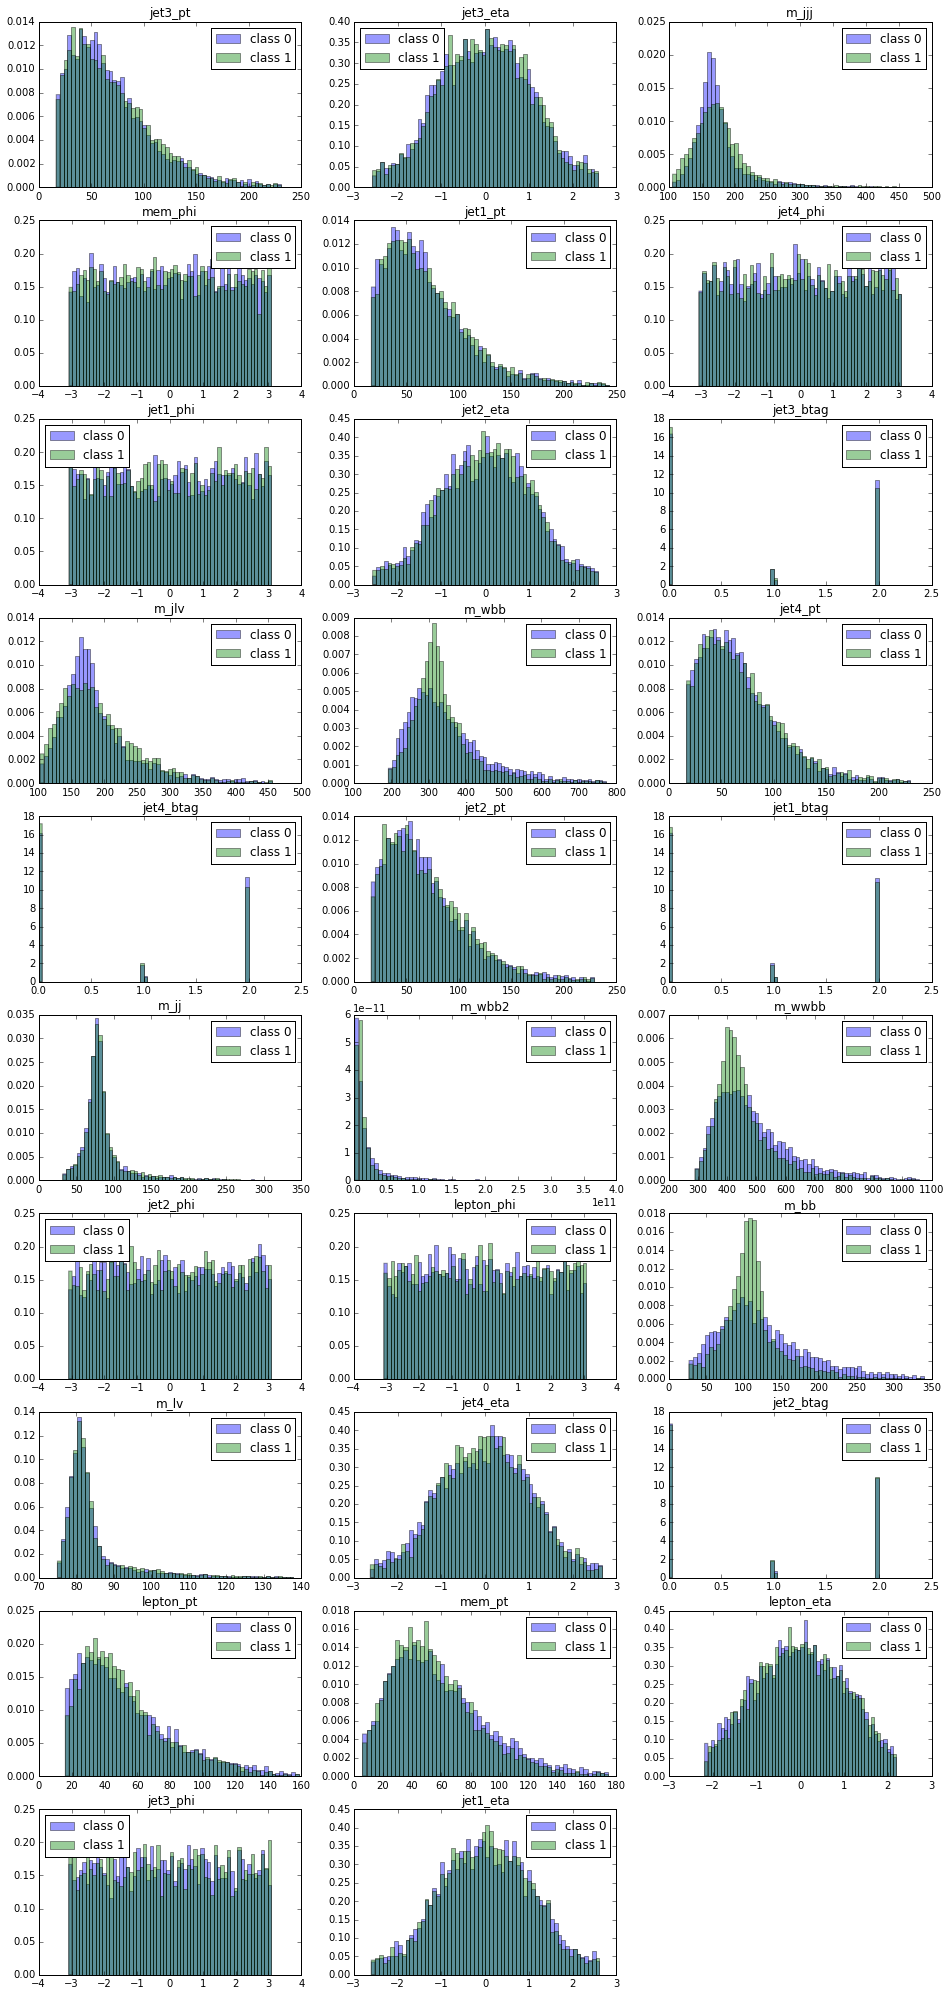

In [80]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 35))
for n, feature in enumerate(features):
    # add sub plot on our figure
    plt.subplot(9+1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = np.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

## Simple knn from sklearn

In [9]:
knn_cv = cross_val_score(KNeighborsClassifier(n_neighbors=6),
                data[high_level_features],
                data["target"],
                cv=4, n_jobs=4, scoring="roc_auc")
print knn_cv.mean(), knn_cv.std()

0.721489324587 0.000947318341457


## RandomForrest

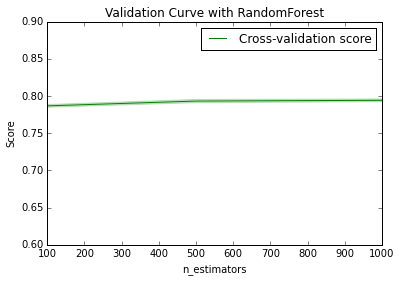

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import validation_curve
#rf_cv = cross_val_score(RandomForestClassifier(n_jobs=4, n_estimators=50),
#                        data[high_level_features],
#                        data["target"], scoring='roc_auc', cv=4)
#print rf_cv.mean(), rf_cv.std()
param_range = [100, 500,1000]
param_name = 'n_estimators'
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=4),
                                             data[features],
                                             data["target"], scoring='roc_auc', cv=4,
                                             param_name=param_name,
                                             param_range=param_range)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.ylim(0.6, 0.9)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [88]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
#clf = make_pipeline(, RandomForestClassifier(n_jobs=4, n_estimators=100))
clf = RandomForestClassifier(n_jobs=4, n_estimators=500)
rf_cv = cross_val_score(clf,
                        #data[high_level_features],
                        data[features],
                        data["target"], scoring='roc_auc', cv=4)
print rf_cv.mean(), rf_cv.std()

0.766977667738 0.00403227268805


0.767

## Prepare submission to kaggle

In [17]:
# predict test sample
kaggle_proba = knn.predict_proba(test[high_level_features])[:, 1]
kaggle_ids = test.event_id

In [18]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/Users/antares/Yandex.Disk.localized/projects/MLHEP/mlhep2016/higgs_kaggle/datasets/baseline.csv